# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Прочитаем файл /datasets/real_estate_data.csv и сохраним его в переменной data.

In [561]:
import pandas as pd


data = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
pd.set_option('display.max_columns', None)
data.head() # Выводим первые пять строк таблицы.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Общая информация о данных таблицы *data*.

In [562]:
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

1. В датафрейме содержится информация о 23699 обектах недвижимости, каждый из которых описывается 22 признаками.
2. Изучив данные таблицы можно заметить большое количество пропусков в разных столбца. Они могут быть как случайными, так и неслучайными.
3. Значения столбца last_price для наглядности лучше перевести в млн.
4. Можем видеть несоответсвие типов данных некоторых столбцов - *first_day_exposition*, *is_apartment*.

### Шаг 2. Предобработка данных

### Обработка пропусков

Проверяем данные на наличие пропусков.

In [563]:
  data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Создадим функцию для того, что бы узнать какую часть составляют пропуски в каждом столбце.

In [564]:
def nan_part(row):
    return 'Пропуски составляют {:.1%}'.format(data[row].isna().sum() / len(data))

#### Высота потолков (*ceiling_height*) - разумно будет заменить пропущенные значения на медиану.

In [565]:
mean_height = data['ceiling_height'].mean()
data['ceiling_height'] = data['ceiling_height'].fillna(mean_height)
# data['ceiling_height'].unique()

# data['ceiling_height'].describe()

<font color=brown>Можно пойти немного дальше и заполнить высоту потолков медианами в соответствии с этажностью. Ведь у пятиэтажек, девятиэтажек и т.д. высота потолков должна быть более-менее одинкова.

Часть значений были введены вручную с ошибками (25 вместо 2.5 и т.д.). В дальнейшем нужно будет исправить значения так как высота потолка не может быть двузначным числом или меньше 2.5 метров ( а в данных встречаются значения вплоть до 1 м)

#### Количество этажей (*floors_total*).

In [566]:
nan_part('floors_total')

'Пропуски составляют 0.4%'

Узнать количество этажей в доме не представляется возможным, при этом пропущенные значения составляют 0.4%, поэтому их просто удалим.

In [567]:
data.dropna(subset=['floors_total'], inplace=True)

#### Жилая площадь (*living_area*).

Предполагаю, что существует зависимость между площадью квартиры *total_area* и жилой площадью *living_area*, но пока не знаю, как это можно реализовать. Поэтому вновь воспользуемся медианой :)

In [568]:
data['living_attitude'] = data['living_area'] / data['total_area']
living_mean = data['living_attitude'].mean()
data['living_area'] = data['living_area'].fillna(living_mean * data['total_area'])

#### Апартаменты (*is_apartment*)

In [569]:
nan_part('is_apartment')

'Пропуски составляют 88.2%'

Подобное количество пропусков образовалось, скорей всего, из-за того, что люди попросту пропускали данный пункт, ввиду того, что квартиры не являлись апартаментами. Все пропуски заменим на *False*.

In [570]:
data['is_apartment'] = data['is_apartment'].fillna(False) # Весь столбец стал типа bool

In [571]:
data['kitchen_attitude'] = data['kitchen_area'] / data['total_area']
kitchen_mean = data['kitchen_attitude'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_mean * data['total_area'])

#### Площадь кухни (*kitchen_area*)
Поступим в аналогии с жилой площадью.

In [572]:
data['kitchen_attitude'] = data['kitchen_area'] / data['total_area']
kitchen_mean = data['kitchen_attitude'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_mean * data['total_area'])

#### Число балконов (*balcony*)
Видимо все отсутствующие значения - это соответствие тому, что балконов нет вообще. Следовательно заменим пропуски на "0".

In [573]:
data['balcony'] = data['balcony'].fillna(0)

#### Название населённого пункта (*locality_name*)

In [574]:
nan_part('locality_name')

'Пропуски составляют 0.2%'

Видимо не все хотят сразу показать в какой "глуши" продается недвижимость, что бы не пугать потенциальных покупателей.
Ввиду того, что эти данные будут использоваться в анализе, а заполнение пропусков точными значениями весьма затруднительно (хотя можно попыхтеть над Яндекс картами), все пропуски удалим.

In [575]:
data.dropna(subset=['locality_name'], inplace=True)

#### Расстояние до ближайшего аэропорта (*airports_nearest*), число парков в радиусе 3 км (*parks_around3000*), расстояние до ближайшего парка (*parks_nearest*), число водоёмов в радиусе 3 км (*ponds_around3000 *), расстояние до ближайшего водоёма (*ponds_nearest*)

Значения в этих признаках не представляют интереса для нашего исследования, следовательно все пропуски осавим без изменений.

In [576]:
'''data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)'''

"data['airports_nearest'] = data['airports_nearest'].fillna(0)\ndata['parks_around3000'] = data['parks_around3000'].fillna(0)\ndata['parks_nearest'] = data['parks_nearest'].fillna(0)\ndata['ponds_around3000'] = data['ponds_around3000'].fillna(0)\ndata['ponds_nearest'] = data['ponds_nearest'].fillna(0)"

#### Расстояние до центра города (*cityCenters_nearest*)

Трудоемкост заполнения пропущенных значений весьма велика, поэтому будет лучше оставить эти данные без изменения.

#### Сколько дней было размещено объявление (от публикации до снятия) (*days_exposition*)

Пропущенные значения заменим на медиану.

In [577]:
median_exposition = data['days_exposition'].median()
data['days_exposition'] = data['days_exposition'].fillna(median_exposition)

<font color='brown'>Здесь замена всех пропусков на единый средний день будет также недостоверной. Это может исказить средние и вообще, отразится на распределении.  
Кроме того, пропуски здесь могут означать просто то, что объявление еще не снято с публикации.

### Замена типа данных

Тип данных столбца *first_day_exposition* нужно перевести в тип  *datetime*.

In [578]:
# data['first_day_exposition'].head()

In [579]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Данные столбца *floors_total* (количество этажей) и *balcony* (количество балконов) приведем к целочисленным значениям, ведь этажей или балконов не может быть полтора и т.д.

In [580]:
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data.info() # Проверяем результаты предобработки, кажется данные стали менее страшными.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around

### Шаг 3. Посчитайте и добавьте в таблицу

Цена квадратного метра:

In [581]:
data['metre_price'] = round(data['last_price'] / data['total_area'], 1) # Цена за квадратный метр.

День недели, месяц и год публикации: 

In [582]:
data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Этаж квартиры (первый, последний, другой):

In [583]:
# Создадим функцию для определения варианта этажа.
def floor_category(row): 
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [584]:
data['floor_category'] = data.apply(floor_category, axis=1)

In [667]:
'''data['floor_category_new'] = data['floor'].where(data['floor'] == 0, 'другой')
data['floor_category_new'] = data['floor_category_new'].where(data['floor'] <= (data['floors_total'] - 1), 'последний')
data['floor_category_new'] = data['floor_category_new'].where(data['floor'] > 1, 'первый')'''


"data['floor_category_new'] = data['floor'].where(data['floor'] == 0, 'другой')\ndata['floor_category_new'] = data['floor_category_new'].where(data['floor'] <= (data['floors_total'] - 1), 'последний')\ndata['floor_category_new'] = data['floor_category_new'].where(data['floor'] > 1, 'первый')"

Соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [586]:
data['living_area_ratio'] = round(data['living_area'] / data['total_area'], 3) # Жилая площадь к общей.
data['kitchen_area_ratio'] = round(data['kitchen_area'] / data['total_area'], 3) # Площадь кухни к общей.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### 4.1.1 Изучение параметров площади, цены, числа комнат и высоты потолков

In [587]:
import matplotlib.pyplot as plt

Так как в дальнейшем нам потребуется избавиться от редких и выбивающихся значений, создадим функцию, определяющую границу "усов" в диаграмме размаха, для определения диапазона нормальных значений.

In [588]:
def box(row):
    values = data[row].describe()
    iqr = values[6] - values[4] # Межквартильный размах
    left = values[4] - 1.5 * iqr # Левый "ус"
    right = values[6] + 1.5 * iqr # Правый "ус"
    # Забыл, что левый "ус" не может быть меньше минимума, а правый больше максимума (исправил)
    if left < values[3]:
        left = values[3]
    if right > values[7]:
        right = values[7]
    return left, right

In [589]:
box('total_area') # Левый и правый "ус" для площади.

(12.0, 114.25)

In [590]:
data['total_area'].describe() # Список характерных значений для площади.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

(0, 150)

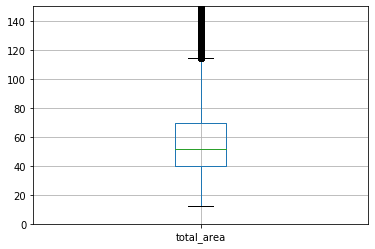

In [591]:
data.boxplot(column='total_area') # Диаграмма размаха для общей площади.
plt.ylim(0, 150)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd152cc2690>]],
      dtype=object)

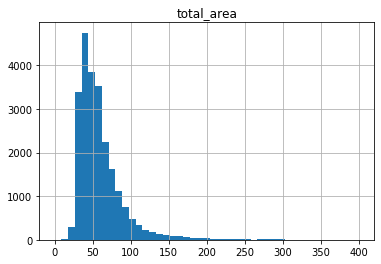

In [592]:
data.hist('total_area', bins=45, range=(0, 400)) # Гистограмма для общей площади.

In [593]:
box('last_price') # Левый и правый "ус" для цены.

(12190.0, 11875000.0)

In [594]:
# Цены переведем в млн. для наглядности.
data['last_price'] = data['last_price'] / 1000000 
data['last_price'].describe() # Список характерных значений для цены.
# На мой взгляд, очень велико значение стандартного отклонения.

count    23565.000000
mean         6.540058
std         10.910935
min          0.012190
25%          3.400000
50%          4.646000
75%          6.790000
max        763.000000
Name: last_price, dtype: float64

(-1, 15)

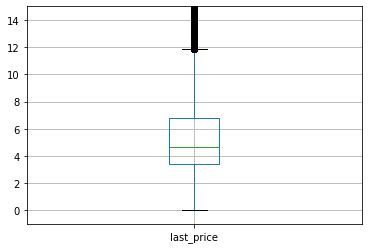

In [595]:
data.boxplot(column='last_price') # Диаграмма размаха для цены.
plt.ylim(-1, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd152b6f5d0>]],
      dtype=object)

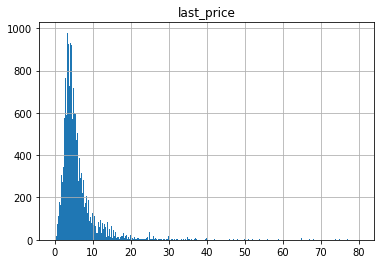

In [596]:
data.hist('last_price', bins=450, range=(0, 80)) # Гистограмма для цены.

In [597]:
box('rooms') # Левый и правый "ус" для числа комнат.

(0.0, 6.0)

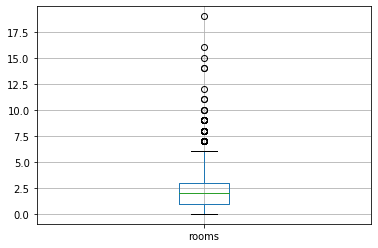

In [598]:
data.boxplot(column='rooms') # Диаграмма размаха для числа комнат.

In [599]:
data['rooms'].describe() # Список характерных значений для числа комнат.

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd154971fd0>]],
      dtype=object)

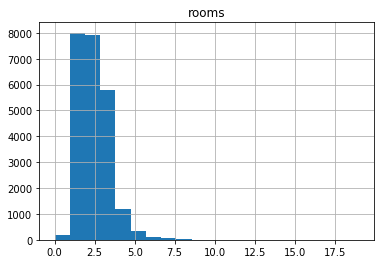

In [600]:
data.hist('rooms', bins=20) # Гистограмма для числа комнат.

In [601]:
box('ceiling_height') # Левый и правый "ус" для высоты потолков.

(2.3427516547159404, 3.0287472421400996)

(2, 3)

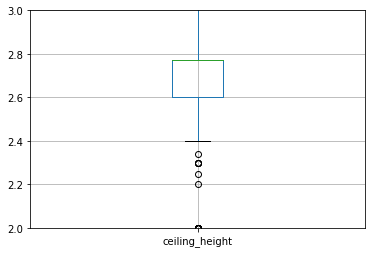

In [602]:
data.boxplot(column='ceiling_height')  # Диаграмма размаха для высоты потолков.
plt.ylim(2, 3)

In [603]:
data['ceiling_height'].describe() # Список характерных значений для высоты потолков.

count    23565.000000
mean         2.771366
std          0.989266
min          1.000000
25%          2.600000
50%          2.771499
75%          2.771499
max        100.000000
Name: ceiling_height, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1530b0490>]],
      dtype=object)

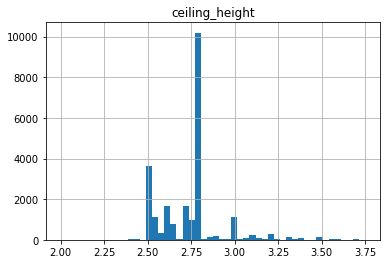

In [604]:
data.hist('ceiling_height', bins=50, range=(2, 3.75)) # Гистограмма для высоты потолков.


### 4.1.2 Изучение данных о времени продажи квартир

In [605]:
box('days_exposition') 

(1.0, 427.5)

(-10, 500)

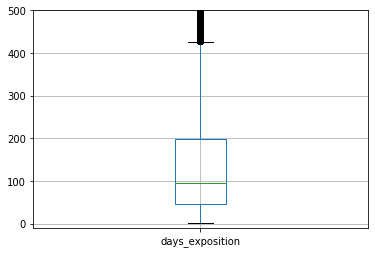

In [606]:
data.boxplot(column='days_exposition')
plt.ylim(-10, 500)

In [607]:
data['days_exposition'].describe()

count    23565.000000
mean       169.203692
std        206.497729
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

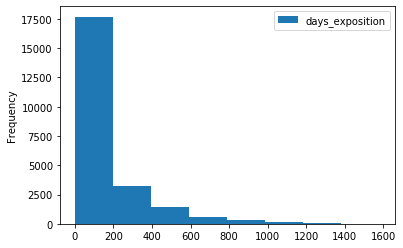

In [608]:
data.plot(y='days_exposition', 
          kind='hist', 
          bins=8)

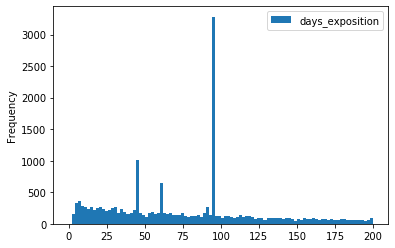

In [609]:
data.plot(y='days_exposition', 
          kind='hist', 
          bins=100, range=(0,200))

Очень сильно выделяются 40 и 60 дней продажи!

Скорей всего на 45-й и 60-й день, в зависимости от типа объявления, на сервисе происходит автоматическая деактивация объявлений. Можно как вариант не рассматривать эти строки,как несостоявшиеся сделки.

#### Вывод

Средними продаваемыми являются двухкомнатные квартиры, с площадью в 52 квадратных метра, высотой потолка 2.65 метра, продаваемые за 4.7 млн. рублей.
Нам встречаются такие аномалии, как:
    1. Квартиры с площадью более 114.25 кв.м. (на основе диаграммы размаха)
    2. Цена более 11.9 млн. рублей
    3. Количество комнат больше 6
    4. Высота потолков более 2.85 метров и ниже 2.45 метров.

В основном продажа квартиры занимала 95 дней (3 месяца). 25% всей недвижимости была продана за 45 дней, что составляет чуть больше месяца и настораживает (возможно мошенничество), а самое долгое время продажи составило 427 дней (14 месяцев) - может быть квартира уже была давно куплена, а бывший владелец забыл убрать объявление о продаже.

### 4.2 Убираем редкие и выбивающиеся значения

Добавим в таблицу столбцы булевого типа, обозначающие аномальные значения.

In [610]:
data['big_area'] = data['total_area'] > box('total_area')[1]
data['very_expensive'] = data['last_price'] > box('last_price')[1] 
data['too_many_rooms'] = data['rooms'] > box('rooms')[1]
data['very_low_ceiling'] = data['ceiling_height'] < box('ceiling_height')[0]
data['very_hight_ceiling'] = data['ceiling_height'] > box('ceiling_height')[1]
data['too_slow'] = data['days_exposition'] > box('days_exposition')[1]
data['too_fast'] = data['days_exposition'] < 30

Создадим новый датафрейм *good_data* без редких и выбивающихся значений.

In [611]:
good_data = data[(data['big_area'] == False) &
                (data['very_expensive'] == False) &
                (data['too_many_rooms'] == False) &
                (data['very_low_ceiling'] == False) &
                (data['very_hight_ceiling'] == False) &
                (data['too_slow'] == False) &
                (data['too_fast'] == False)].reset_index(drop=True)
# good_data.info()

Попробовал создать аналогичную таблицу с помощью срезов - *good_data_query* (правда так и не понял как записать столь длинную строку в столбик).
Получилось на 366 строк меньше, чем в *good_data*. Решил использовать датафрейм *good_data*.

In [612]:
# good_data_query = data.query('12.0 < total_area < 114.25 and 0.01219 < last_price < 11.875 and 0.0 < rooms < 6.0 and 2.45 < ceiling_height < 2.85 and 30 < days_exposition < 427.5')
# good_data_query.info()

In [613]:
anomaly_values = data.shape[0] - good_data.shape[0]
part_anomaly = anomaly_values / data.shape[0]
print('Доля удаленных аномальных значений составляет {:.2%}'.format(part_anomaly))
print()
print('Доля чистых значений составляет {:.2%}'.format(good_data.shape[0] / data.shape[0]))

Доля удаленных аномальных значений составляет 34.89%

Доля чистых значений составляет 65.11%


In [1]:
# Как вариант, можно чуть менее аггрессивно выбрать границы отрезания данных, например, высота потолков более 3-х метров. 
# Мы не обязаны строго следовать границам "усов" диаграммы размаха.

### 4.3 Влияние факторов на стоимость квартиры

Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

#### Определение pависимости цены от  общей площади, числа комнат, удалённости от центра.

In [614]:
column = ['big_area', 'very_expensive', 'too_many_rooms', 'very_low_ceiling', 'very_hight_ceiling', 'too_slow', 'too_fast']
good_data.drop(column, inplace=True, axis=1)

In [615]:
# Срез столбцов с необходимыми значениями
good_data_corr = good_data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']] 
# Вызовем матрицу корреляции
good_data_corr.corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.677669,0.408059,-0.310876
total_area,0.677669,1.000000,0.801760,-0.079210
rooms,0.408059,0.801760,1.000000,-0.042944
cityCenters_nearest,-0.310876,-0.079210,-0.042944,1.000000


In [616]:
# pd.plotting.scatter_matrix(good_data_corr, figsize=(11, 11)) # Матрица рассеяния для четырех величин.

Построим график зависимости цены от площади.

Text(0.5, 0, 'Общая площадь (кв.м.)')

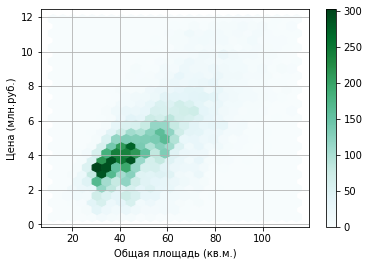

In [617]:
good_data.plot(kind='hexbin', x='total_area', y='last_price', gridsize=25, grid=True, sharex=False)
plt.ylabel('Цена (млн.руб.)')
plt.xlabel('Общая площадь (кв.м.)')

In [618]:
round(good_data['total_area'].corr(good_data['last_price']), 2) # Узнаем коэффициент корреляции

0.68

Построим график зависимости цены от числа комнат.

Text(0.5, 0, 'Число комнат')

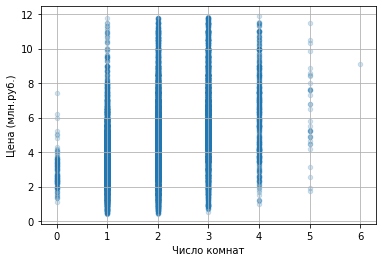

In [619]:
good_data.plot(kind='scatter', x='rooms', y='last_price',grid=True, alpha=0.2)
plt.ylabel('Цена (млн.руб.)')
plt.xlabel('Число комнат')

In [620]:
round(good_data['rooms'].corr(good_data['last_price']), 2) # Узнаем коэффициент корреляции

0.41

Построим график зависимости цены от удаленности от центра.

Text(0.5, 0, 'Расстояние до центра (м.)')

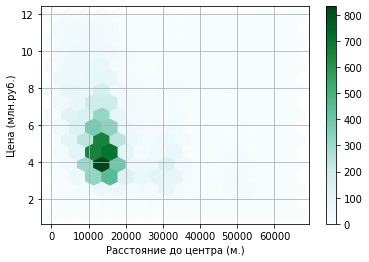

In [621]:
good_data.plot(kind='hexbin', x='cityCenters_nearest', y='last_price', gridsize=15, grid=True, sharex=False)
plt.ylabel('Цена (млн.руб.)')
plt.xlabel('Расстояние до центра (м.)')

In [622]:
round(good_data['cityCenters_nearest'].corr(good_data['last_price']), 2) # Узнаем коэффициент корреляции

-0.31

Сгруппируем таблицу по столбцу `floor_category` и определим максимальное, медианное и минимальное значения для того, что бы понять какие этажи более дорогие.

In [623]:
data_floor = good_data.groupby('floor_category')['last_price'].agg(['count', 'max', 'median', 'min'])
data_floor

,count,max,median,min
floor_category,,,,
другой,11197,11.86686,4.5,0.45
первый,2050,11.75759,3.7,0.43
последний,2096,11.80000,3.9,0.43


<font color='brown'>Ниже ты пишешь, что мы не наблюдали зависимости между этажом и ценой. Но, как по мне, она здесь налицо - разница 600-700 тысяч.

Не нашел такого вывода, в 4-м пункте выводов написано,что квартиры на первом и последнем этажах продаются, как правило, по более низкой цене, чем квартиры на других этажах. :-)

Определим зависимости цены от даты размещения.


In [624]:
'''date_of_placing = good_data[['last_price', 'day', 'month', 'year']]
date_of_placing = date_of_placing.corr()
date_of_placing['last_price']'''

"date_of_placing = good_data[['last_price', 'day', 'month', 'year']]\ndate_of_placing = date_of_placing.corr()\ndate_of_placing['last_price']"

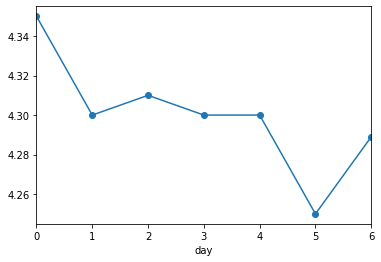

In [625]:
day_price = good_data.groupby('day')['last_price'].median()
day_price.plot(style='-o')

<BarContainer object of 7 artists>

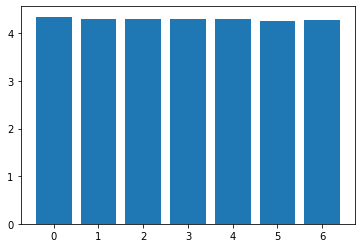

In [626]:
plt.bar(day_price.index, day_price)

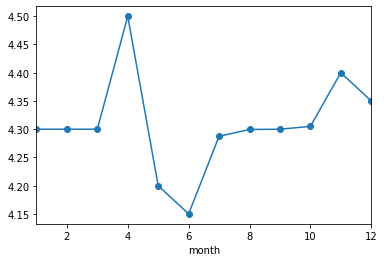

In [627]:
month_price = good_data.groupby('month')['last_price'].median()
month_price.plot(style='-o')

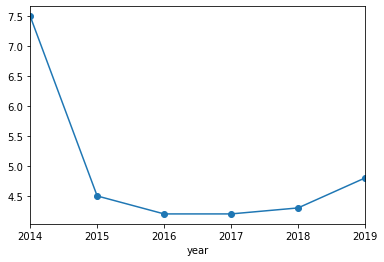

In [628]:
year_price = good_data.groupby('year')['last_price'].median()
year_price.plot(style='-o')

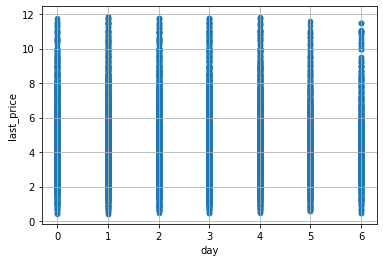

In [629]:
good_data.plot(kind='scatter', y='last_price', x='day', grid=True)

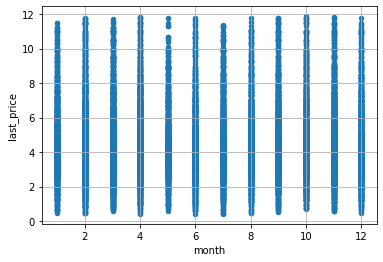

In [630]:
good_data.plot(kind='scatter', y='last_price', x='month', grid=True)

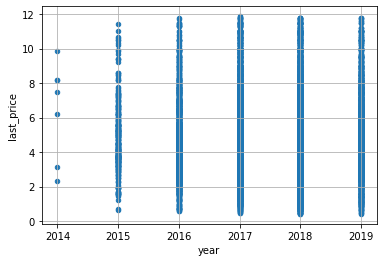

In [631]:
good_data.plot(kind='scatter', y='last_price', x='year', grid=True)

#### Вывод
    1. Видна прямопропорциональная зависимость между ценой о общейплощадью, следовательно чем больше площадь, тем дороже квартира, что подтверждается наиболее сильной корреляцией (коэфф. корреляции 0.67).
    2. Зависимость цены от числа комнат не столь явная, как от площади. Цена растет в пределах 3-х комнат. При этом пяти- шестикомнатные стоят дешевле. Видимо на них низкий спрос (коэфф. корреляции 0.4).
    3. Расстояние до центра города очевидно тоже влияет на цену, но обратнопропорционально (коэфф. корреляции -0.3).
    4.Квартиры на первом и последнем этажах продаются, как правило, по более низкой цене, чем квартиры на других этажах.
    5. День недели и месяц не играют значимой роли на цену продаваемой недвижимости. Исследование лишь показало чуть большую зависимость цены от года, но скорей всего это можно отнести к макроэкономической ситуации.
    5.1 Анализ новых графиков показал неболшую разницу в цене в зависимости от дня недели - самые высокие цены по понедельникам, самые низкие по пятницам. Так же видна небольшая разница цены в зависимости от месяца - апрель и ноябрь являются месяцами чуть больших цен. Большая разница ощутима по годам - 2014 год самый дорогой.

### 4.4 Населенные пункты с наибольшим числом объявлений

In [632]:
# good_data['locality_name'].unique()

Можно провести лемматизацию названий, но при ознакомлении не выявлено повторяющихся названий.

Определим десятку населенных пунктов с самым большим количеством объявлений и посчитаем среднюю цену за квадратный метр в каждом из них.

In [633]:
locality_price = (good_data
                  .pivot_table(index='locality_name', values='metre_price', aggfunc=('count', 'median'))
                  .sort_values(by='count', ascending=False)[:10])

# Не уверен, что это правельный метод для округления
# locality_price['median'] = locality_price['median'].apply(lambda i: '{:.2f}'.format(i)) 

locality_price = locality_price.sort_values(by='median', ascending=False)

locality_price

# Правильно ли я понял, что мы выделяем населенные пункты с высокой и низкой стоимостью жилья
# на выведенных десяти? :-)

,count,median
locality_name,,
Санкт-Петербург,9364,102113.80
Пушкин,250,98454.75
деревня Кудрово,212,92225.05
посёлок Парголово,248,91145.25
посёлок Мурино,364,85714.30
посёлок Шушары,337,76584.50
Колпино,237,74324.30
Гатчина,227,67187.50
Всеволожск,312,65855.80


#### Вывод

Из представленной десятки населенных пунктов с самым большим количеством объявлений лидерами по высокой средней цене за квадратный метр являются *Санкт-Петербург*, *Пушкин* и *деревня Кудрово*.

Самая низкая цена в *Выборге*.

В глаза бросается то, что цена в деревне выше цены в городе. В дальнейшем нужно будет уточнить, есть ли здесь зависимость от расположения населенного пункта относительно центра *Санкт-Петербурга*.

### 4.4 Определение центра Санкт-Петербурга

Создадим столбец с расстояние до центра в километрах.

In [634]:
# good_data['cityCenters_nearest'].fillna(0, inplace=True)

# Кучу времени убил на попытку привести к целому числу, пришлось обходиться тем, что есть, и то это не особо помогло
good_data['nearest_center_km'] = round(good_data['cityCenters_nearest'] / 1000, 0).astype("int", errors='ignore')

Получим срез данных для Санкт-Петербурга.

In [635]:
good_spb_city = good_data.query('locality_name == "Санкт-Петербург"')

Посчитаем среднюю цену для каждого километра и построим график для определения центральной зоны.

In [636]:
good_spb_city_grouped = good_spb_city.groupby('nearest_center_km')['last_price'].median()
good_spb_city_grouped.head()

nearest_center_km
0.0    6.100
1.0    7.700
2.0    8.075
3.0    7.360
4.0    7.000
Name: last_price, dtype: float64

<BarContainer object of 30 artists>

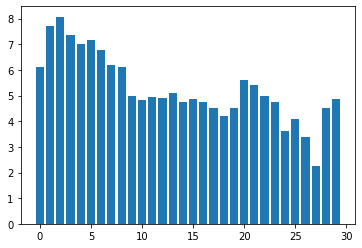

In [637]:
plt.bar(good_spb_city_grouped.index, good_spb_city_grouped)

#### Вывод

Таким образом, исходя из графика будем считать центром *Санкт-Петербурга* окружность радиусом 8 км.

### 4.5 Анализ квартир в центре Санкт-Петербурга

Создадим новую таблицу с квартирами, удаленными от центра не более чем на 8 километров.

In [638]:
center_spb_city = good_spb_city.query('nearest_center_km < 9')

# center_spb_city.head()

# center_spb_city['nearest_center_km'].value_counts() # Проверим какие значения вошли.

print('Всего в центре {} квартиры.'.format(center_spb_city.shape[0]))

Всего в центре 1451 квартиры.


In [639]:
center_spb_city.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_attitude,kitchen_attitude,metre_price,day,month,year,floor_category,floor_category_new,living_area_ratio,kitchen_area_ratio,nearest_center_km
14,8,6.50,97.2,2015-10-31,2,2.771499,3,46.5,1,False,False,False,19.6,0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0,0.478395,0.201646,66872.4,5,10,2015,первый,Другой,0.478,0.202,2.0
68,32,9.60,90.0,2017-09-26,4,2.771499,5,67.0,2,False,False,False,8.0,0,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0,0.744444,0.088889,106666.7,1,9,2017,другой,Другой,0.744,0.089,3.0
76,4,4.59,40.0,2017-05-29,1,2.771499,6,18.0,1,False,False,False,10.0,0,Санкт-Петербург,20062.0,6175.0,1.0,241.0,0.0,NaN,31.0,0.450000,0.250000,114750.0,0,5,2017,первый,Другой,0.450,0.250,6.0
79,5,4.00,21.4,2019-02-07,1,2.900000,8,8.3,7,False,False,False,6.3,0,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,95.0,0.387850,0.294393,186915.9,3,2,2019,другой,Другой,0.388,0.294,6.0
96,8,4.80,40.0,2017-11-18,2,2.771499,3,29.0,2,False,False,False,6.0,0,Санкт-Петербург,23371.0,2913.0,0.0,NaN,2.0,729.0,80.0,0.725000,0.150000,120000.0,5,11,2017,другой,Другой,0.725,0.150,3.0


Проанализируем такие параметры, как: площадь, цена, число комнат и высота потолков.

count    1451.000000
mean       61.203577
std        19.970270
min        12.000000
25%        45.000000
50%        59.500000
75%        75.000000
max       114.200000
Name: total_area, dtype: float64


Text(0, 0.5, 'Общая площадь')

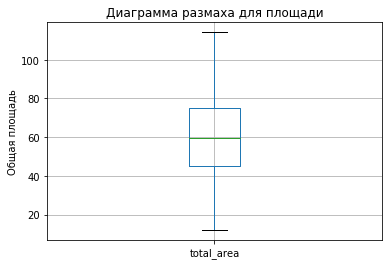

In [640]:
print(center_spb_city['total_area'].describe())
center_spb_city.boxplot(column='total_area')
plt.title('Диаграмма размаха для площади')
plt.ylabel('Общая площадь')

count    1451.000000
mean        7.057587
std         2.170974
min         2.250000
25%         5.400000
50%         6.830000
75%         8.601500
max        11.866860
Name: last_price, dtype: float64


Text(0, 0.5, 'Цена млн.')

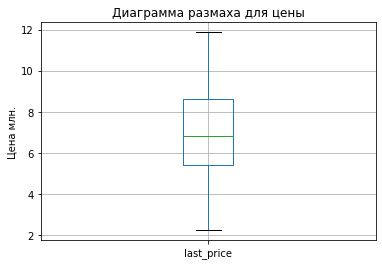

In [641]:
print(center_spb_city['last_price'].describe())
center_spb_city.boxplot(column='last_price')
plt.title('Диаграмма размаха для цены')
plt.ylabel('Цена млн.')

count    1451.000000
mean        2.155755
std         0.924308
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64


Text(0, 0.5, 'Число комнат')

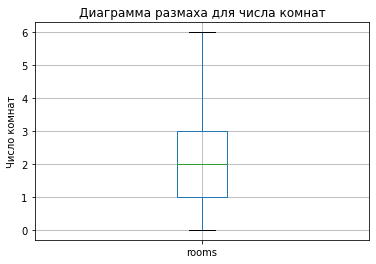

In [642]:
print(center_spb_city['rooms'].describe())
center_spb_city.boxplot(column='rooms')
plt.title('Диаграмма размаха для числа комнат')
plt.ylabel('Число комнат')

count    1451.000000
mean        2.777215
std         0.136476
min         2.400000
25%         2.750000
50%         2.771499
75%         2.800000
max         3.020000
Name: ceiling_height, dtype: float64


Text(0, 0.5, 'Высота потолков')

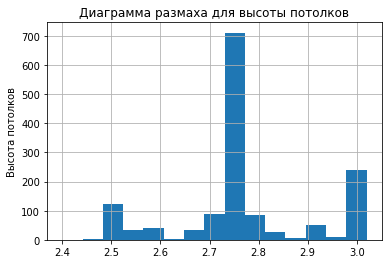

In [643]:
print(center_spb_city['ceiling_height'].describe())
center_spb_city.hist('ceiling_height',bins=15)
plt.title('Диаграмма размаха для высоты потолков')
plt.ylabel('Высота потолков')

Определим факторы, влияющие на стоимость квартиры.

#### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [644]:
# center_spb_city.plot(kind='hexbin', x='rooms', y='last_price', gridsize=35, grid=True, sharex=False)

In [645]:
import seaborn as sns

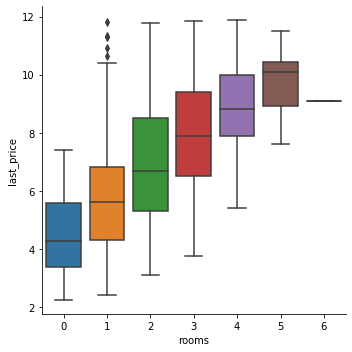

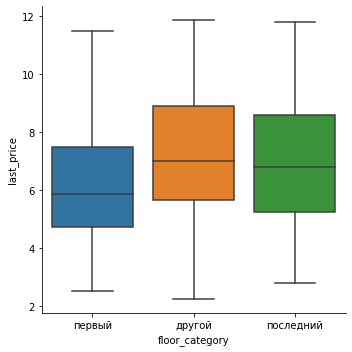

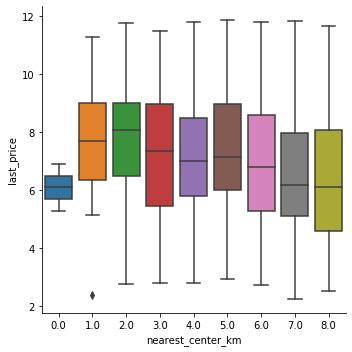

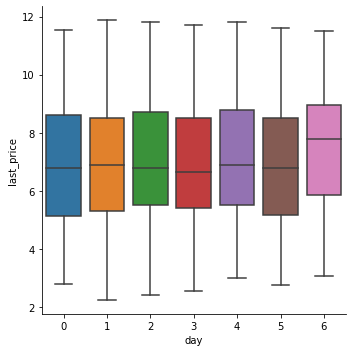

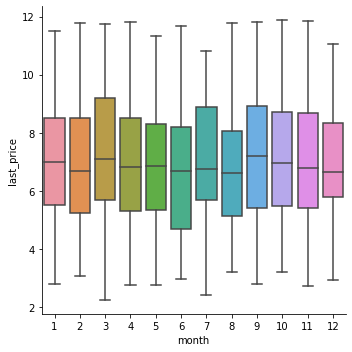

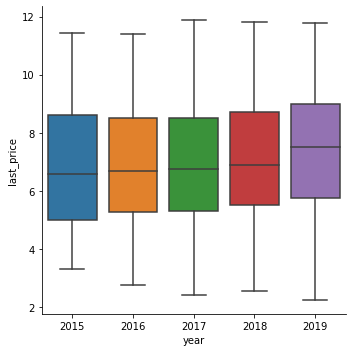

In [646]:
for column in ['rooms', 'floor_category', 'nearest_center_km', 'day', 'month', 'year']:
    sns.catplot(x=column, y="last_price", kind="box", data=center_spb_city)

#### Вывод.

1. Анализ параметров: площадь, цена, число комнат, высота потолков.

 - Средняя квартира, выставленная на продажу в *Санкт-Петербурге* - это 2-х комнатная квартира с площадью 60 кв.м. и высотой   потолков равной 2.65 метра, выставленная по цене 6.8 млн. рублей.

2. Факторы, влияющие на стоимость квартиры.

 - Зависимость цены от числа комнат, показывает, что в центре *Санкт -Петербурга* наиболее дорогими являются пятикомнатные квартиры, следовательно на них есть спрос. Из графика видна прямопропорциональная зависимость.
 - В окрестностях мы не наблюдали явной зависимоти между этажем и ценой. В центре же прослеживается тенденция к продаже квартир на последнем этаже по более высокой цене, относительно квартир на первом. Красивый вид на центр культурной столицы хочет каждый.
 - Прслеживается обратнопропорциональная зависимость цены от удаленности от центра - чем дальше в глубинку, тем дешевле квартира.
 - Весьма интересно, что квартиры, заявленные на продажу в восресенье продавались по более высокой цене. Может по выходным у продавцов больше амбиций. Тоже касается и месяцев - в марте и сентябре квартиры дороже. 

### Шаг 5. Общий вывод

Из проведенного анализа можно сделать вывод, что для определения рыночной стоимости объектов недвижимости важны следующие параметры:
 - общая площадь квартиры 
 - расстояние до центра города (в пределах радиуса 8-ми километров)
 - число комнат и этаж квартиры ( чем ближе к центру, тем эти фаторы важнее)
 - Исходя из того, что данные о высоте потолков вбивались вручную (скорей всего), необходимо ввести ограничения на ввод данных о высоте (что бы избегать 20, 30, 100 метров и т.д.)
 - необходимо обращать внимание на срок продажи квартиры (до 1 месяца - слишком быстрая продажа (особенно аномальны сроки до 2-х недель), слишком долгая продажа - более 427 дней (14 месяцев))

С уважением. Беляев Антон. :-)

<font color='green'>Вывод содержит описание всех результатов проведенного анализа и дает ответы на поставленные в задании вопросы. Хорошо.

<font color=green>С оформлением у нас также все отлично: структура проекта соблюдена, комментарии аккуратны и в подходящих ячейках. Код читабелен и откомментирован.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод